# plotting cross-chain attention

This code plots the cross-chain attention of our representative therapetuic mAb, Masavibart. Before using this notebook, you must use the Extract-Cross-Chain-Attention.ipynb file to export a csv file with the attention values.

### imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

### extract average attention

In [2]:
def avg_attention(cc_attention_df):
    layer_dfs = []
    for layer in sorted(cc_attention_df["layer"].unique()):

        head_dfs = []
        for head in sorted(cc_attention_df["head"].unique()):
            cc_attention_sq = pd.pivot(
                data = cc_attention_df[(cc_attention_df["layer"] == layer) & (cc_attention_df["head"] == head)], 
                index="position1", 
                columns="position2", 
                values="attention",
            )

            hlen = sum(cc_attention_sq[1].isna())
            hl_sqdf = cc_attention_sq.iloc[:hlen, hlen:]
            lh_sqdf = cc_attention_sq.iloc[hlen:, :hlen].T

            sum_sqdf = hl_sqdf + lh_sqdf / 2 # average

            head_dfs.append(sum_sqdf)

        # average of all 20 heads
        head_dfs = sum(head_dfs) / 20
        layer_dfs.append(head_dfs)

    # average of all 33 layers
    avg_layer_dfs = sum(layer_dfs) / 33
    return avg_layer_dfs

In [3]:
# Import full-attention file
masavibart_full = pd.read_csv('./attention-results/Masavibart.csv')

# Extract cross-chain attention values and extract average attention
masavibart_cc = masavibart_full[masavibart_full["comparison"] == "cross-chain"]
masavibart_df = avg_attention(masavibart_cc)

### extract heavy and light chain values

In [4]:
subtract_val = int(masavibart_df.columns[0]) - 1
masavibart_df.columns = [int(c) - subtract_val for c in masavibart_df.columns]
masavibart_df.columns.name = "light chain"

In [5]:
# heavy-chain values
hc_vals = masavibart_df.sum(axis=1)
hc_vals = (hc_vals - hc_vals.min()) / (hc_vals.max() - hc_vals.min())

hc_vals = [f"{k}\t{v}" for k, v in hc_vals.items()]

In [6]:
# light-chain values
lc_vals = masavibart_df.sum(axis=0)
lc_vals = (lc_vals - lc_vals.min()) / (lc_vals.max() - lc_vals.min())

lc_vals = [f"{k}\t{v}" for k, v in lc_vals.items()]

### CDR & cysteine positions for Masavibart

In [7]:
hcdr_positions = {
    "CDR1": [25, 33],
    "CDR2": [50, 58],
    "CDR3": [96, 109],
}

lcdr_positions = {
    "CDR1": [26, 35],
    "CDR2": [52, 55],
    "CDR3": [91, 101],
}

h_cysteines = [21, 95]
l_cysteines = [22, 90]

### plot heatmap

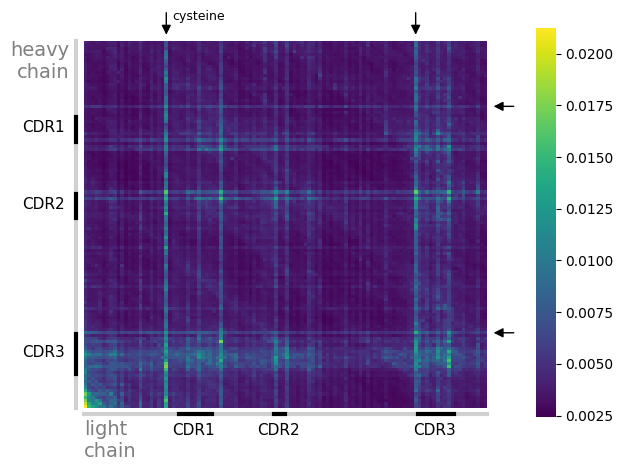

In [8]:
sns.heatmap(data=masavibart_df, cmap="viridis")

ax = plt.gca()

# set up the ticks and labels (CDR1/2/3 labels)
xlabels = sorted(lcdr_positions.keys())
ylabels = sorted(hcdr_positions.keys())

xticks = [np.mean(lcdr_positions[l]) - 0.5 for l in ylabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, va="center", ha="center")
ax.tick_params(axis="x", labelrotation=0, width=0, pad=6, labelsize=11)


yticks = [np.mean(hcdr_positions[l]) - 0.5 for l in xlabels]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels, va="center", ha="right")
ax.tick_params(axis="y", labelrotation=0, width=0, pad=2, labelsize=11)


# x/y axis limits
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()


# plot the CDR position lines
plt.plot([-2, -2], [ymin, ymax], color="#D0D0D0", linewidth=3)
for region in hcdr_positions:
    minval, maxval = hcdr_positions[region]
    plt.plot([-2, -2], [minval, maxval], color="k", linewidth=3)
ax.set_xlim([-3, xmax + 6])

plt.plot([xmin, xmax], [ymin + 2, ymin + 2], color="#D0D0D0", linewidth=3)
for region in lcdr_positions:
    minval, maxval = lcdr_positions[region]
    plt.plot([minval, maxval], [ymin + 2, ymin + 2], color="k", linewidth=3)
ax.set_ylim([ymin + 3, ymax - 4])


# add markers for light chain cysteines
for cys in l_cysteines:
    ax.annotate(
        "", 
        xy=[cys + 0.5, ymax - 1],
        xytext=[cys + 0.5, ymax - 10],
            arrowprops={
                "arrowstyle": "-|>", 
                "mutation_scale": 14,
                "facecolor": "k",
                "edgecolor": "k",
            },
    )
ax.text(l_cysteines[0] + 2, ymax - 10, "cysteine", ha="left", va="top", fontsize=9)


for cys in h_cysteines:
    ax.annotate(
        "", 
        xy=[xmax + 1, cys + 0.5],
        xytext=[xmax + 8, cys + 0.5],
            arrowprops={
                "arrowstyle": "-|>", 
                "mutation_scale": 14,
                "facecolor": "k",
                "edgecolor": "k",
            },
    )


# add heavy/light chain labels
ax.set_xlabel("", fontsize=0)
ax.set_ylabel("", fontsize=0)
ax.text(-4, ymax, "heavy\nchain", ha="right", va="top", rotation=0, fontsize=14, color="grey")
ax.text(ymax, ymin + 4, "light\nchain", ha="left", va="top", fontsize=14, color="grey")

plt.tight_layout()
plt.show()

### plot heavy-chain attention linearly

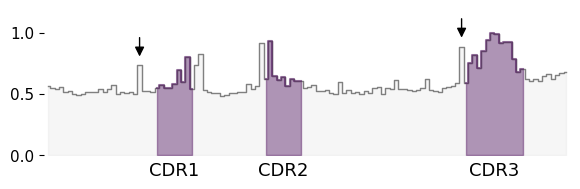

In [9]:
df = masavibart_df

plt.figure(figsize=[6, 2])

max_val = df.sum(axis=1).max()

plt.step(
    x=range(df.shape[0]), 
    # y=df.sum(axis=1),
    y=df.sum(axis=1) / max_val,
    where="mid",
    color="grey",
    lw=1,
)

plt.fill_between(
    x=range(df.shape[0]), 
    # y1=df.sum(axis=1),
    y1=df.sum(axis=1) / max_val,
    alpha=0.2,
    color="lightgrey",
    step="mid",
)

ax = plt.gca()

for s in ax.spines:
    ax.spines[s].set_visible(False)
    

ax.set_xticks([])
label_offset = 0.05

for region in hcdr_positions:
    start, end = hcdr_positions[region]
    # plt.hlines(-0.025, start, end, color="k")
    plt.text(
        x=start + ((end - start) / 2), 
        y=-label_offset, 
        s=region, 
        va="top", 
        ha="center",
        fontsize=13,
    )
    plt.step(
        x=range(start, end + 1), 
        # y=df.sum(axis=1)[start:end + 1],
        y=df.sum(axis=1)[start:end + 1] / max_val,
        where="mid",
        # color="r",
        color=plt.colormaps["viridis"](0),
        alpha=0.5,
        lw=1.5,
    )
    plt.fill_between(
        x=range(start, end + 1), 
        # y1=df.sum(axis=1)[start:end + 1],
        y1=df.sum(axis=1)[start:end + 1] / max_val,
        alpha=0.4,
        # color="r",
        color=plt.colormaps["viridis"](0),
        step="mid",
    )

# arrow_offset = df.sum(axis=1).max() * 0.05
arrow_offset = 0.05
arrow_length = arrow_offset * 5

for cys in h_cysteines:
    ax.annotate(
        "", 
        xy=[cys, (df.sum(axis=1) / max_val)[cys + 1] + arrow_offset],
        xytext=[cys, (df.sum(axis=1) / max_val)[cys + 1] + arrow_length],
            arrowprops={
                "arrowstyle": "-|>", 
                "mutation_scale": 14,
                "facecolor": "k",
                "edgecolor": "k",
            },
    )

ax.set_xlim([-1, 120])    

ax.tick_params(axis="y", labelsize=11)
ax.set_ylim([0, 1.19])

plt.tight_layout()
plt.show()

### plot light-chain attention linearly

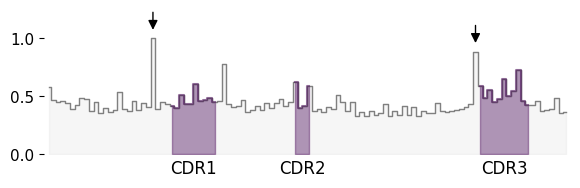

In [10]:
df = masavibart_df.T

plt.figure(figsize=[6, 2])

max_val = df.sum(axis=1).max()

plt.step(
    x=range(df.shape[0]), 
    # y=df.sum(axis=1),
    y=df.sum(axis=1) / max_val,
    where="mid",
    color="grey",
    lw=1,
)

plt.fill_between(
    x=range(df.shape[0]), 
    # y1=df.sum(axis=1),
    y1=df.sum(axis=1) / max_val,
    alpha=0.2,
    color="lightgrey",
    step="mid",
)

ax = plt.gca()

for s in ax.spines:
    ax.spines[s].set_visible(False)
    
ax.set_xticks([])

label_offset = 0.05

for region in lcdr_positions:
    start, end = lcdr_positions[region]
    plt.text(
        x=start + ((end - start) / 2), 
        y=-label_offset, 
        s=region, 
        va="top", 
        ha="center",
        fontsize=12,
    )
    plt.step(
        x=range(start, end + 1), 
        y=(df.sum(axis=1) / max_val)[start:end + 1],
        where="mid",
        # color="r",
        color=plt.colormaps["viridis"](0),
        alpha=0.5,
        lw=1.5,
    )
    plt.fill_between(
        x=range(start, end + 1), 
        y1=(df.sum(axis=1) / max_val)[start:end + 1],
        alpha=0.4,
        # color="r",
        color=plt.colormaps["viridis"](0),
        step="mid",
    )

arrow_offset = 0.05
arrow_length = arrow_offset * 5

for cys in l_cysteines:
        ax.annotate(
        "", 
        xy=[cys,(df.sum(axis=1) / max_val)[cys + 1] + arrow_offset],
        xytext=[cys, (df.sum(axis=1) / max_val)[cys + 1] + arrow_length],
            arrowprops={
                "arrowstyle": "-|>", 
                "mutation_scale": 14,
                "facecolor": "k",
                "edgecolor": "k",
            },
    )
        

ax.set_xlim([-1, 110])

ax.tick_params(axis="y", labelsize=11)
ax.set_ylim([0, 1.19])

plt.tight_layout()
plt.show()